# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification.

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [ ]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries. 필요한 라이브러리 추가로 호출

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [ ]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                         transforms.RandomCrop(32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


plane  bird   car  ship


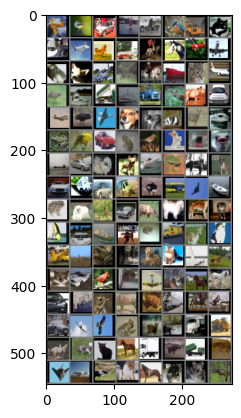

In [ ]:
# Examples of dataset 데이터가 잘 만들어졌음을 확인가능.

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [ ]:
# Model

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_prob=0.5):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.conv_block = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  # Dropout 추가

            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.out_channels),
            nn.Dropout(dropout_prob)   # Dropout 추가
        )

        if self.stride != 1 or self.in_channels != self.out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.out_channels)
            )

    def forward(self, x):
        out = self.conv_block(x)
        if self.stride != 1 or self.in_channels != self.out_channels:
            x = self.downsample(x)
        out = F.relu(x + out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10, dropout_prob=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.base = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = self.make_layer(64, num_blocks[0], stride=1, dropout_prob=dropout_prob)
        self.layer2 = self.make_layer(128, num_blocks[1], stride=2, dropout_prob=dropout_prob)
        self.layer3 = self.make_layer(256, num_blocks[2], stride=2, dropout_prob=dropout_prob)
        self.layer4 = self.make_layer(512, num_blocks[3], stride=2, dropout_prob=dropout_prob)

        self.gap = nn.AvgPool2d(4)
        self.fc = nn.Sequential(
            nn.Dropout(dropout_prob),  # Dropout 추가
            nn.Linear(512, num_classes)
        )

    def make_layer(self, out_channels, num_block, stride, dropout_prob):
        strides = [stride] + [1] * (num_block - 1)
        layers = []

        for stride in strides:
            block = ResidualBlock(self.in_channels, out_channels, stride, dropout_prob)
            layers.append(block)
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.gap(out)

        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

num_blocks=[3,4,6,3]
net = ResNet(num_blocks, dropout_prob=0.5).to(device) #dropout


# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [ ]:
def modeltype(model):
    if model == 'resnet18':
        return ResNet([2, 2, 2, 2], dropout_prob=0.5)
    elif model == 'resnet34':
        return ResNet([3, 4, 6, 3], dropout_prob=0.5)

learning_rate = 1e-3

model = modeltype('resnet34').to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

criterion = nn.CrossEntropyLoss()

GroundTruth:    cat  ship  ship plane
Predicted:    car plane   car  deer


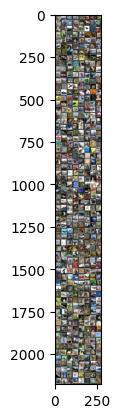

In [ ]:
# Test the trained model with sample 고치면 안된다.

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = model(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

# **Train the network**

Train your own network using the above loss function and optimizer.

In [ ]:
# Train the model

train_accuracy = []
test_accuracies = []

epochs = 100

for epoch in range(epochs):
    correct = 0
    total = 0
    loss_tmp = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, start=0):
        # Load the data
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Estimate the output using the network
        outputs = model(inputs)

        # Calculate the loss between the output of the network and label
        loss = loss_func(outputs, labels) #loss 함수 계산

        # Optimize the network 네트워크 한번 업데이트
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_tmp += loss.data
        epoch_loss += loss.data
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 5000 == 4999:
            print('[Epoch - %d, Iteration - %5d] Loss: %.3f' %
                  (epoch + 1, i + 1, loss_tmp / (i+1)))
            loss_tmp = 0.0

    # Update the learning rate according to the learnig rate scheduler
    scheduler.step()

     # 에포크가 끝날 때마다 정확도를 train_accuracy 리스트에 추가
    epoch_accuracy = 100 * correct / total
    train_accuracy.append(epoch_accuracy)

    print(f'Epoch [{epoch+1}], Loss: {epoch_loss/(i+1):.4f}, Accuracy: {epoch_accuracy:.2f}%')

print('Finished Training')

Epoch [1], Loss: 1.9790, Accuracy: 27.04%
Epoch [2], Loss: 1.4803, Accuracy: 45.89%
Epoch [3], Loss: 1.2498, Accuracy: 54.68%
Epoch [4], Loss: 1.1115, Accuracy: 60.59%
Epoch [5], Loss: 1.0029, Accuracy: 64.65%
Epoch [6], Loss: 0.9159, Accuracy: 67.79%
Epoch [7], Loss: 0.8554, Accuracy: 69.92%
Epoch [8], Loss: 0.8089, Accuracy: 71.79%
Epoch [9], Loss: 0.7453, Accuracy: 74.13%
Epoch [10], Loss: 0.6979, Accuracy: 75.86%
Finished Training


## **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network.

The closer the accuray is to 100%, the better the network classifies the input image.

Epoch 10, Test Accuracy: 77.76%


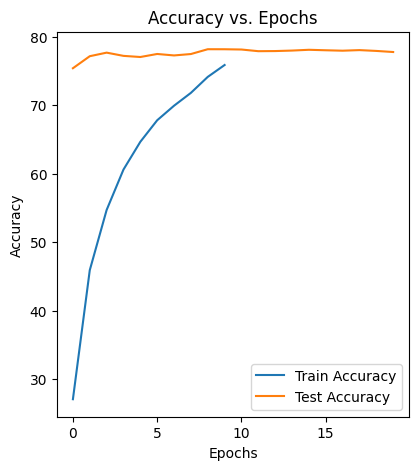

In [ ]:
    # Test the trained model with overall test dataset

    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            inputs_test, labels_test = data
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)

            outputs_test = model(inputs_test)
            loss = criterion(outputs_test, labels_test)
            test_loss += loss.item()

            _, predicted = torch.max(outputs_test.data, 1)
            total += labels_test.size(0)
            correct += (predicted == labels_test).sum().item()

            test_loss /= len(testloader)
            test_accuracy = 100 * correct / total
            test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}, Test Accuracy: {test_accuracy:.2f}%')

    #epochs = len(train_accuracy)
    Epochs = len(train_accuracy)
    EPochs = len(test_accuracies)

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(Epochs), train_accuracy, label='Train Accuracy')
plt.plot(range(EPochs), test_accuracies, label='Test Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()